# Grad-CAM

In [42]:
import torch
import os
import copy
import numpy as np
from PIL import Image
import matplotlib.cm as mpl_color_map
from torch.autograd import Variable
from torchvision import models
from matplotlib.colors import LogNorm
from astropy.io import fits
import torch.nn as nn
import matplotlib.pyplot as plt
from skimage.transform import resize
from CNN_Networks import OU200_CNN, VIS_CNN, JYH_CNN, OU66_CNN

In [43]:
def Get200Images(name):
    images = np.zeros((1,4,200,200))
    image_data1 = fits.getdata('EUC_J/imageEUC_J-'+str(name)+'.fits', ext=0)
    image_data1 = resize(image_data1, (200,200))
    J = (image_data1-np.amin(image_data1))/(np.amax(image_data1)-np.amin(image_data1))
    
    image_data1 = fits.getdata('EUC_Y/imageEUC_Y-'+str(name)+'.fits', ext=0)
    image_data1 = resize(image_data1, (200,200))
    Y = (image_data1-np.amin(image_data1))/(np.amax(image_data1)-np.amin(image_data1))
    
    image_data1 = fits.getdata('EUC_H/imageEUC_H-'+str(name)+'.fits', ext=0)
    image_data1 = resize(image_data1, (200,200))
    H = (image_data1-np.amin(image_data1))/(np.amax(image_data1)-np.amin(image_data1))
    
    image_data1 = fits.getdata('EUC_VIS/imageEUC_VIS-'+str(name)+'.fits', ext=0)
    #image_data1 = resize(image_data1, (200,200))
    VIS = (image_data1-np.amin(image_data1))/(np.amax(image_data1)-np.amin(image_data1))
    
    
    images[0,0] = J
    images[0,1] = Y
    images[0,2] = H
    images[0,3] = VIS
    #images = torch.from_numpy(images)
    
    return images

In [44]:
def convert_to_grayscale(im_as_arr):
    """
#        Converts 3d image to grayscale
#
#    Args:
#        im_as_arr (numpy arr): RGB image with shape (D,W,H)#
#
#    returns:
#        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
#    """
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im

In [45]:
def save_gradient_images(gradient, file_name):
    """
        Exports the original gradient image

    Args:
        gradient (np arr): Numpy array of the gradient with shape (3, 224, 224)
        file_name (str): File name to be exported
    """
    if not os.path.exists('results'):
        os.makedirs('results')
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    # Save image
    path_to_file = os.path.join('results', file_name + '.jpg')
    save_image_BP(gradient, path_to_file)
    return gradient

In [46]:
def get_example_params(example_index, name):  
    #original_image = fits.getdata(img_path, ext=0)
    original_image = Get200Images(name)
    img_path = 'EUC_VIS/imageEUC_VIS-'+str(name)+'.fits'
    target_class = example_index
    file_name_to_export = img_path[img_path.rfind('/')+1:img_path.rfind('.')]
    prep_img = preprocess_image(original_image)
    return (original_image,
            prep_img,
            target_class,
            file_name_to_export)

In [47]:
def preprocess_image(pil_im, resize_im=True):
    image = pil_im
    im_as_ten = torch.from_numpy(image).float()
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var

In [48]:
def save_image_gradCam(im, path):
    fig = plt.imshow(im)
    plt.axis('off')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.savefig(str(path)+'.pdf', bbox_inches='tight',dpi=300)

In [49]:
def save_image_BP(im, path):
    fig = plt.imshow(im[0])
    plt.axis('off')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.savefig(str(path)+'.pdf', bbox_inches='tight',dpi=300)
    return im

In [50]:
def save_class_activation_images(org_img, activation_map, file_name):
    if not os.path.exists('results'):
        os.makedirs('results')
    # Grayscale activation map
    heatmap, heatmap_on_image = apply_colormap_on_image(org_img, activation_map, 'hsv')
    # Save colored heatmap
    path_to_file = os.path.join('results', file_name+'_'+str(target_class)+'_Cam_Heatmap.png')
    save_image_gradCam(heatmap, path_to_file)
    # Save heatmap on iamge
    path_to_file = os.path.join('results', file_name+'_'+str(target_class)+'_Cam_On_Image.png')
    save_image_gradCam(heatmap_on_image, path_to_file)
    # SAve grayscale heatmap
    path_to_file = os.path.join('results', file_name+'_'+str(target_class)+'_Cam_Grayscale.png')
    save_image_gradCam(activation_map, path_to_file)

In [51]:
def get_positive_negative_saliency(gradient):
    """
        Generates positive and negative saliency maps based on the gradient
    Args:
        gradient (numpy arr): Gradient of the operation to visualize

    returns:
        pos_saliency ( )
    """
    pos_saliency = (np.maximum(0, gradient) / gradient.max())
    neg_saliency = (np.maximum(0, -gradient) / -gradient.min())
    return pos_saliency, neg_saliency

In [52]:
def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on iamge
    org_im = Image.fromarray(np.uint8(org_im*255))
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image

In [53]:
class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.layer._modules.items():
            x = module(x)  # Forward
            if int(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                #print(x)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.fc_layer(x)
        #print(x)
        return conv_output, x

In [54]:
class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        print(one_hot_output)
        one_hot_output[0][target_class] = 1 
        print(target_class)
        print(one_hot_output)
        # Zero grads
        self.model.layer.zero_grad()
        self.model.fc_layer.zero_grad()
        # Backward pass with specified target
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        # Get hooked gradients
        guided_gradients = self.extractor.gradients.data.numpy()[0]
        #print(guided_gradients)
        # Get convolution outputs
        target = conv_output.data.numpy()[0]
        # Get weights from gradients
        weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # Multiply each weight with its conv output and then, sum
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.ANTIALIAS))/255
        return cam

In [55]:
class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        first_layer = list(self.model.layer._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for pos, module in self.model.layer._modules.items():
            if isinstance(module, nn.ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward pass
        model_output = self.model(input_image)
        model_output = model_output[0]
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1 #target_class
        # Backward pass
        model_output.backward(gradient=one_hot_output[0])
        # Convert Pytorch variable to numpy array
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

In [56]:
def guided_grad_cam(grad_cam_mask, guided_backprop_mask):
    """
        Guided grad cam is just pointwise multiplication of cam mask and
        guided backprop mask

    Args:
        grad_cam_mask (np_arr): Class activation map mask
        guided_backprop_mask (np_arr):Guided backprop mask
    """
    cam_gb = np.multiply(grad_cam_mask, guided_backprop_mask)
    return cam_gb

## Load States
A dictionary containing all the weights for the CNNs used in the accompanning paper. 

In [57]:
loadStates = {'J': 'OU_J_Weights.pt',
              'Y': 'OU_Y_Weights.pt',
              'H': 'OU_H_Weights.pt',
              'JYH': 'OU_JYH_Weights.pt',
              'VIS': 'OU_VIS_Weights.pt',
              'OU-66': 'OU_66_Weights.pt',
              'OU-200': 'OU_200_Weights.pt'}

## Making Gudied Grad-CAM


tensor([[0., 0.]])
1
tensor([[0., 1.]])
Grad cam completed
Guided backpropagation completed
Guided grad cam completed


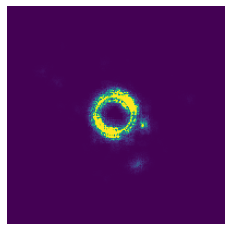

In [58]:
if __name__ == '__main__':
    # Get params
    name = 252238
    target_example = 1  # Snake
    target_layer = 20
    (original_image, prep_img, target_class, file_name_to_export) =\
        get_example_params(target_example, name)
    
    model = OU200_CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model.load_state_dict(torch.load(loadStates['OU-200'],map_location=torch.device('cpu')))
    
    pretrained_model = model

    # Grad cam
    gcv2 = GradCam(pretrained_model, target_layer=target_layer)  # Up to layer 20
    # Generate cam mask
    cam = gcv2.generate_cam(prep_img, target_class)
    print('Grad cam completed')

    # Guided backprop
    GBP = GuidedBackprop(pretrained_model)
    # Get gradients
    guided_grads = GBP.generate_gradients(prep_img, target_class)
    print('Guided backpropagation completed')

    # Guided Grad cam
    cam_gb = guided_grad_cam(cam, guided_grads)
    guided_GradCAM_numpy_1 = save_gradient_images(cam_gb, file_name_to_export + '_'+str(target_layer)+'_'+str(target_class)+'_GGrad_Cam')
    np.save(file_name_to_export + '_'+str(target_layer)+'_'+str(target_class)+'_GGrad_Cam', cam_gb)
    grayscale_cam_gb = convert_to_grayscale(cam_gb)
    guided_GradCAM_numpy_BP_1 = save_gradient_images(grayscale_cam_gb, file_name_to_export + '_'+str(target_layer)+ '_'+str(target_class)+'_GGrad_Cam_gray')
    np.save(file_name_to_export + '_'+str(target_layer)+'_'+str(target_class)+'_GGrad_Cam_gray', grayscale_cam_gb)
    print('Guided grad cam completed')